# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [262]:
import numpy as np
from scipy import misc
from importlib import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [263]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    # TODO: compute the values of prior for each class!
    # ==========================
    for idx, k in enumerate(classes):
        prior[idx] = np.sum(labels==k)/Npts
    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))
    # TODO: fill in the code to compute mu and sigma!
    # ==========================
    for jdx, k in enumerate(classes):
        idx = np.where(labels==k)[0]
        Xk = X[idx,:] # Get the x for the class labels. Vectors are rows.
        Wk = W[idx]
        mu[jdx,:] = Wk.T @ Xk /float(np.sum(Wk))   
        sigma_diag = np.sum(Wk*(Xk - mu[jdx,:])**2, axis=0) /float(np.sum(Wk))
        sigma[jdx,:,:] = np.diag(sigma_diag)
    # ==========================

    return mu, sigma

#main:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):
    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    # print("(C, d), N: ", mu.shape,",",Npts )
    # print("prior shape: ",prior.shape)
    logProb = np.zeros((Nclasses, Npts))

    # TODO: fill in the code to compute the log posterior logProb!
    # ==========================
    diagonals = np.diagonal(sigma, axis1=1, axis2=2)
    inv_diag = 1.0/diagonals
    determinants = np.prod(diagonals, axis=1)

    # Compute the difference between X and mu for all classes and all points
    diff = X[:, np.newaxis, :] - mu  # N x C x d, broadcasting the differences
    
    # 1. First term: log(determinants), broadcast manually to (Nclasses, Npts)
    logProb += -0.5 * np.log(determinants)[:, np.newaxis]  # Shape (3, 1) but will broadcast

    # 2. Second term: Mahalanobis term, ensuring proper broadcasting
    logProb += -0.5 * np.sum(diff**2 * inv_diag[np.newaxis, :, :], axis=2).T  # Shape: (3, 45)

    # 3. Third term: log(prior), broadcast manually to (Nclasses, Npts)
    logProb += np.log(prior).reshape(-1, 1)
    # ==========================
    
    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb, axis=0).reshape(-1,1)
    #print("h shape: ",h.shape)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [264]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

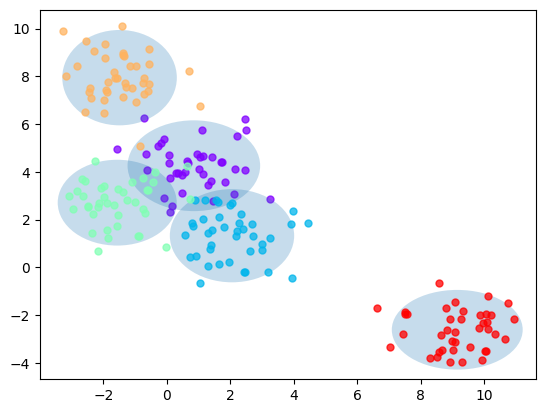

In [265]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [266]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 33.3
Trial: 10 Accuracy 33.3
Trial: 20 Accuracy 33.3
Trial: 30 Accuracy 33.3
Trial: 40 Accuracy 33.3
Trial: 50 Accuracy 33.3
Trial: 60 Accuracy 33.3
Trial: 70 Accuracy 33.3
Trial: 80 Accuracy 33.3
Trial: 90 Accuracy 33.3
Final mean classification accuracy  33.3 with standard deviation 0


In [267]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 9.09
Trial: 10 Accuracy 9.09
Trial: 20 Accuracy 9.09
Trial: 30 Accuracy 9.09
Trial: 40 Accuracy 9.09
Trial: 50 Accuracy 9.09
Trial: 60 Accuracy 9.09
Trial: 70 Accuracy 9.09
Trial: 80 Accuracy 9.09
Trial: 90 Accuracy 9.09
Final mean classification accuracy  9.09 with standard deviation 1.78e-15


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

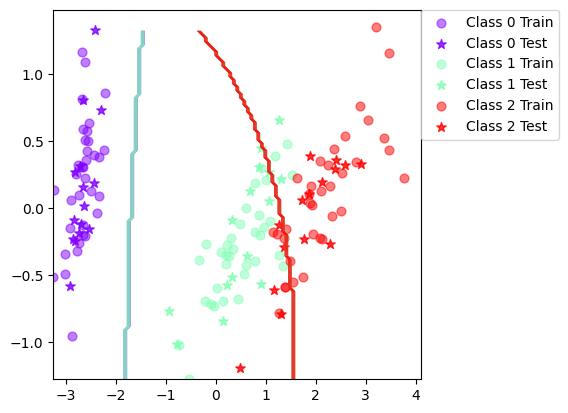

In [258]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

## Assignment 3 - Questions

##### (1) When can a feature independence assumption be reasonable and when not?

The feature independence assumption, commonly known as **the naive Bayes assumption**, assumes that the features in a dataset are conditionally independent given the class label. This means that, given the class, the presence or value of one feature does not influence the others.

**When It’s Reasonable:**
* In practice with simple models: Even though features might be dependent in reality, the naive Bayes model often performs well due to its simplicity, especially in high-dimensional datasets where modeling dependencies is complex.
When features are almost independent: For example, in text classification (e.g., spam detection), where each word in an email can be treated as relatively independent of the others, naive Bayes models work surprisingly well.
* In the presence of high-dimensional data: In domains with many features, the independence assumption can reduce computational complexity and allow the model to scale.

**When It’s Not Reasonable:**
* When features are highly correlated: If two or more features are strongly dependent, treating them as independent can mislead the model. For instance, in medical data, symptoms are often correlated, and assuming independence may lead to poor performance.
* In continuous domains with strong dependencies: When features exhibit a clear statistical dependency (e.g., height and weight in people), assuming independence can significantly degrade the performance of the model.
Example: In the case of image classification, pixel values in an image are highly correlated with their neighboring pixels, making the independence assumption poor for such tasks.

##### (2) How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?

Since we have three classes, we have two decision for seperating the three clusters of data. The decision boundary on the left is clearly seperating class 0 from the rest of the classes. However, the decision boundry on the right fails to seperate the data of class 1 with the data of class 2. 

Improvements: By using either SVM with a linear kernel and allowing for some slack since it seems like class 1 and 2 are almost linearly separable, with a few outliers, or use a RBF kernel because altought a linear decision boundry could be sufficiently good, the cluesters are not completly linearly seperable and a RBF kernel would probably do a better job at seperating the data.

Other methods could be:

Decision Trees: These could produce flexible, piecewise decision boundaries, especially if the dataset's attribute interactions are non-linear.

Ensemble Methods: Random Forests or Gradient Boosting methods can also improve classification by combining several trees and reducing bias and variance.

## Boosting functions to implement

The lab descriptions state what each function should do.

In [259]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        
        # alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [ ]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [26]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

NameError: name 'BoostClassifier' is not defined

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])